# KNN


In this notebook, a classification model is implemented using the K-Nearest Neighbors (KNN) algorithm.

### Setting up the environment

First, we import the libraries necessary for the analysis of the data, as well as the generation of the KNN model. After this, the training and test datasets are loaded from their respective files.

In [58]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

# Data
X_train_df = pd.read_csv('gold/X_train_df.csv', index_col='respondent_id') # training set features

training_set_labels_df = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id') # training set labels

X_test_df = pd.read_csv('gold/X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('data/submission_format.csv', index_col='respondent_id') # submission format

We split the training dataset into training and validation sets to evaluate model performance.


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

### Modelling

To obtain the best model configuration for KNN, GridSearchCV is used, setting its search with the following parameters:

In [82]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [5, 9, 10, 15, 19],  # Add more values for n_neighbors
    'weights': ['uniform', 'distance'],  # To weight the neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2],  # For the Minkowski metric: 1 = Manhattan, 2 = Euclidean
    'n_jobs': [-1],  # Use all available cores to improve training speed
}

Once the search parameters have been established, the model is fitted with the best parameters, within the given possibilities.

In [95]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_multioutput_knn = grid_search.best_estimator_  # Retrieve the best estimator
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}


d:\Machine Learning - Repo\macler\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Given the nature of the data, a MultiOutputClassifier is needed, which ensures that each output is classified appropriately.

This is then configured with the previously obtained parameters and adjusted for further execution and evaluation.

In [96]:
estimators = MultiOutputClassifier(
    estimator=KNeighborsClassifier(
        n_neighbors=19,
        weights='distance',
        metric='manhattan',
        p=1,
        n_jobs=-1
    )
)

estimators.fit(X_train, y_train)

MultiOutputClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                     n_jobs=-1, n_neighbors=19,
                                                     p=1, weights='distance'))

### Evaluation

To evaluate the model, we first calculate the probabilities of the classes in the test data of X_test. In addition, the results are displayed to check the output.

In [97]:
preds = estimators.predict_proba(X_test)
preds

[array([[0.8024227 , 0.1975773 ],
        [0.52116576, 0.47883424],
        [0.95375197, 0.04624803],
        ...,
        [0.89767078, 0.10232922],
        [0.74007094, 0.25992906],
        [0.840657  , 0.159343  ]]),
 array([[0.74193527, 0.25806473],
        [0.21567273, 0.78432727],
        [0.80188704, 0.19811296],
        ...,
        [0.89734334, 0.10265666],
        [0.43421449, 0.56578551],
        [0.58619333, 0.41380667]])]

With the results of the predictions, we create a dataframe for each sample in the test data. With this, we check its shape and its upper output.

In [98]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.197577,0.258065
1215,0.478834,0.784327
10540,0.046248,0.198113
7407,0.157793,0.617747
14697,0.220883,0.191532


Once everything is organised, the performance of the model is tested with its roc curve. 

To avoid repeating code, a module has been created for its generation, which will then be executed for the two different types.

In [88]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

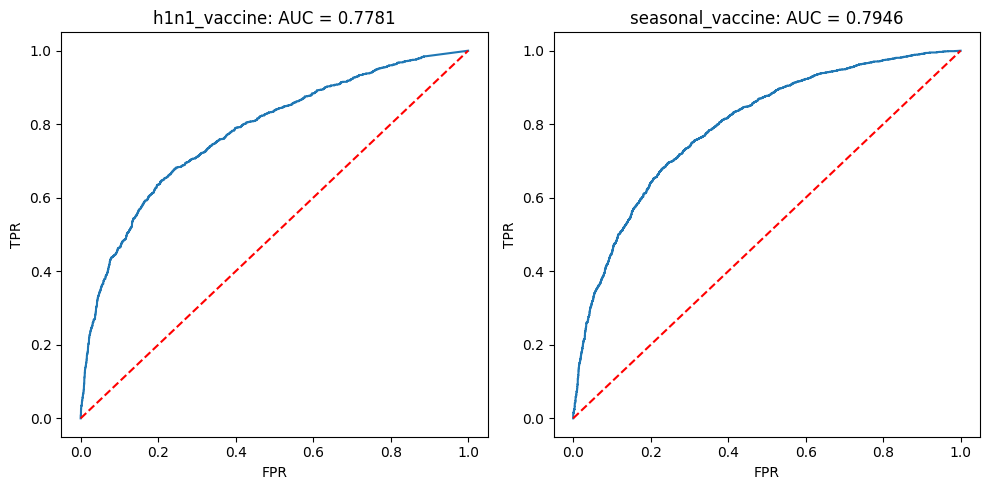

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

### Obtaining results for the competition

Finally, the results are obtained and uploaded to the competition platform. These are stored in the results folder, named *pred_KNN_output.cs*.

In [101]:
estimators.fit(X_train_df, training_set_labels_df)
preds = estimators.predict_proba(X_test_df)
preds

[array([[1.        , 0.        ],
        [1.        , 0.        ],
        [0.53350313, 0.46649687],
        ...,
        [0.77890729, 0.22109271],
        [0.83566843, 0.16433157],
        [0.6211053 , 0.3788947 ]]),
 array([[0.73173881, 0.26826119],
        [1.        , 0.        ],
        [0.26948568, 0.73051432],
        ...,
        [0.63654448, 0.36345552],
        [0.58171974, 0.41828026],
        [0.57129688, 0.42870312]])]

In [102]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.000000,0.268261
26708,0.000000,0.000000
26709,0.466497,0.730514
26710,0.253474,0.768690
26711,0.270651,0.527745


In [93]:
y_preds.to_csv('./results/pred_KNN_output.csv', index = True)